In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os


In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils_pytorch import InducedPolarization
from masa_utils_pytorch import Optimization

In [4]:
parm_true = torch.tensor([np.log(3.25e3), 0.794, np.log(4.17e3), 0.218, 0.686,  np.log(2.52e-6), 0.349], dtype=torch.float32) #, requires_grad=False)
parm_init = torch.tensor([np.log(1e3), 0.5, np.log(1e2), 0.300, 0.50,  np.log(1e-5), 0.40], dtype=torch.float32, requires_grad=True)


In [5]:
#nfreq = torch.tensor(100, dtype=torch.float32)
nfreq = 36
#nfreq_plot = nfreq.item()
freqcen = 1 / torch.exp(parm_true[2])
# freqend_log = torch.log10(torch.tensor(1e10)).item()
# freqstrt_log = torch.log10(torch.tensor(1e-5)).item()
freqend_log = torch.log10(torch.tensor(1e5)).item()
freqstrt_log = torch.log10(torch.tensor(1e-2)).item()
print(freqcen,freqend_log, freqstrt_log)
#freqend_scalar = freqend.item()

freq = torch.logspace(freqstrt_log, freqend_log, nfreq) 
#freq = torch.cat((torch.tensor([0.]), freq))
#freq = torch.logspace(-5, 5, 100) 

freq_plot = freq.detach().numpy()
print(freq.shape)
print(freq)

tensor(0.0002) 5.0 -2.0
torch.Size([36])
tensor([1.0000e-02, 1.5849e-02, 2.5119e-02, 3.9811e-02, 6.3096e-02, 1.0000e-01,
        1.5849e-01, 2.5119e-01, 3.9811e-01, 6.3096e-01, 1.0000e+00, 1.5849e+00,
        2.5119e+00, 3.9811e+00, 6.3096e+00, 1.0000e+01, 1.5849e+01, 2.5119e+01,
        3.9811e+01, 6.3096e+01, 1.0000e+02, 1.5849e+02, 2.5119e+02, 3.9811e+02,
        6.3096e+02, 1.0000e+03, 1.5849e+03, 2.5119e+03, 3.9811e+03, 6.3096e+03,
        1.0000e+04, 1.5849e+04, 2.5119e+04, 3.9811e+04, 6.3096e+04, 1.0000e+05])


In [6]:
Pelton_dual = InducedPolarization(freq=freq)

In [7]:
Pelton_dual.ip_model = Pelton_dual.pelton_res_f_dual
print(Pelton_dual.dpred(parm_true))

tensor([1242.5093, 1197.5197, 1155.1206, 1115.2734, 1077.9153, 1042.9629,
        1010.3154,  979.8578,  951.4639,  924.9985,  900.3199,  877.2809,
         855.7302,  835.5133,  816.4742,  798.4532,  781.2895,  764.8201,
         748.8798,  733.3020,  717.9190,  702.5625,  687.0670,  671.2712,
         655.0228,  638.1843,  620.6400,  602.3043,  583.1312,  563.1230,
         542.3376,  520.8922,  498.9624,  476.7758,  454.5981,  432.7154,
        -157.6781, -149.1829, -140.7352, -132.4225, -124.3213, -116.4977,
        -109.0079, -101.8984,  -95.2075,  -88.9658,  -83.1979,  -77.9234,
         -73.1574,  -68.9124,  -65.1979,  -62.0222,  -59.3915,  -57.3105,
         -55.7815,  -54.8038,  -54.3717,  -54.4729,  -55.0854,  -56.1749,
         -57.6913,  -59.5657,  -61.7079,  -64.0055,  -66.3252,  -68.5170,
         -70.4216,  -71.8814,  -72.7530,  -72.9216,  -72.3125,  -70.8994])


In [8]:

J = Pelton_dual.J(parm_init)
print(J.shape)
print(J)


torch.Size([72, 7])
tensor([[ 6.7823e+02, -6.4086e+02, -3.6284e+01, -2.4710e+02, -1.9213e+00,
         -3.8366e-01,  1.4606e+01],
        [ 6.6172e+02, -6.7335e+02, -3.4571e+01, -2.9409e+02, -2.2512e+00,
         -4.4943e-01,  1.6594e+01],
        [ 6.4601e+02, -7.0412e+02, -3.2626e+01, -3.3270e+02, -2.6382e+00,
         -5.2650e-01,  1.8838e+01],
        [ 6.3121e+02, -7.3295e+02, -3.0517e+01, -3.6260e+02, -3.0928e+00,
         -6.1697e-01,  2.1370e+01],
        [ 6.1735e+02, -7.5973e+02, -2.8311e+01, -3.8385e+02, -3.6281e+00,
         -7.2338e-01,  2.4231e+01],
        [ 6.0447e+02, -7.8437e+02, -2.6066e+01, -3.9692e+02, -4.2595e+00,
         -8.4873e-01,  2.7463e+01],
        [ 5.9255e+02, -8.0685e+02, -2.3835e+01, -4.0254e+02, -5.0056e+00,
         -9.9670e-01,  3.1115e+01],
        [ 5.8158e+02, -8.2717e+02, -2.1659e+01, -4.0159e+02, -5.8888e+00,
         -1.1715e+00,  3.5236e+01],
        [ 5.7151e+02, -8.4538e+02, -1.9572e+01, -3.9509e+02, -6.9356e+00,
         -1.3783e+00,  3.9

In [9]:
relative_error = 0.05
noise_floor = 0. # 1.0 #0.0
dinit = Pelton_dual.dpred(parm_init)

dobs_clean = Pelton_dual.dpred(parm_true)
torch.random.seed()
dobs = ( dobs_clean
    + torch.rand(len(dobs_clean)) * torch.sqrt(
        (relative_error * abs(dobs_clean))**2 
        + noise_floor*torch.ones(len(dobs_clean))**2
    )
    )


In [10]:
opt = Optimization(sim=Pelton_dual, dobs=dobs)
Wd = opt.get_Wd(ratio=relative_error, plateau=noise_floor)
opt.Ws = torch.eye(len(parm_init))

In [11]:
beta0 = opt.BetaEstimate_byEig(mvec=parm_init)
print(beta0)

38895.5703125


In [21]:
niter = 100
mpred,error_prg, mvec_prg = opt.GaussNewton(mvec_init=parm_init,niter=niter,beta0=beta0)



  1, beta:3.9e+04, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
  2, beta:3.9e+04, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
  3, beta:1.9e+04, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
  4, beta:1.9e+04, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
  5, beta:9.7e+03, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
  6, beta:9.7e+03, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
  7, beta:4.9e+03, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
  8, beta:4.9e+03, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
  9, beta:2.4e+03, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
 10, beta:2.4e+03, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
 11, beta:1.2e+03, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
 12, beta:1.2e+03, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
 13, beta:6.1e+02, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
 14, beta:6.1e+02, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
 15, beta:3.0e+02, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
 16, beta:3.0e+02, step:1.2e-04, gradient:1.0e+04,  f:3.2e+03
 17, bet

In [13]:
np_mvec_prg = mvec_prg.detach().numpy()
np_mvec_init = parm_init.detach().numpy()
np_mvec_true = parm_true.detach().numpy()
np_mvec_est = mpred.detach().numpy()
dest = Pelton_dual.dpred(mpred)

In [20]:
print( "Parameter:     res0,  chg1,      tau1,    c1,   chg2,     tau1,    c2")
print(f"initial  : {np.exp(np_mvec_init[0]):.2e}, {np_mvec_init[1]:.3f}, {np.exp(np_mvec_init[2]):.3e}, {np_mvec_init[3]:.3f},  {np_mvec_init[4]:.3f}, {np.exp(np_mvec_init[5]):.2e}, {np_mvec_init[6]:.3f}")
print(f"est      : {np.exp(np_mvec_est[0]):.2e}, {  np_mvec_est[1]:.3f}, {np.exp(np_mvec_est[2]):.3e}, { np_mvec_est[3]:.3f},  { np_mvec_est[4]:.3f}, { np.exp(np_mvec_est[5]):.2e}, { np_mvec_est[6]:.3f}")
print(f"true     : {np.exp(np_mvec_true[0]):.2e}, {  np_mvec_true[1]:.3f}, {np.exp(np_mvec_true[2]):.3e}, { np_mvec_true[3]:.3f},  { np_mvec_true[4]:.3f}, { np.exp(np_mvec_true[5]):.2e}, { np_mvec_true[6]:.3f}")

Parameter:     res0,  chg1,      tau1,    c1,   chg2,     tau1,    c2
initial  : 1.00e+03, 0.500, 1.000e+02, 0.300,  0.500, 1.00e-05, 0.400
est      : 2.12e+03, 0.651, 9.353e+01, 0.283,  0.611, 7.72e-06, 0.351
true     : 3.25e+03, 0.794, 4.170e+03, 0.218,  0.686, 2.52e-06, 0.349


In [15]:
nwindow = len(freq)
dest_real = dest[:nwindow].detach().numpy().flatten()
dest_imag = dest[nwindow:].detach().numpy().flatten()
dest_abs = np.sqrt(dest_real**2 + dest_imag**2)
dest_phase = 1000*np.arctan2(dest_imag, dest_real)
dobs_real = dobs[:nwindow].detach().numpy().flatten()
dobs_imag = dobs[nwindow:].detach().numpy().flatten()
dobs_abs = np.sqrt(dobs_real**2 + dobs_imag**2)
dobs_phase = 1000*np.arctan2(dobs_imag, dobs_real)
dinit_real = dinit[:nwindow].detach().numpy().flatten()
dinit_imag = dinit[nwindow:].detach().numpy().flatten()
dinit_abs = np.sqrt(dinit_real**2 + dinit_imag**2)
dinit_phase = 1000*np.arctan2(dinit_imag, dinit_real)

windows_plot = freq.detach().numpy()

In [16]:
PL_pelton = PsuedoLog(
            logmin=1e-7,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.2)


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


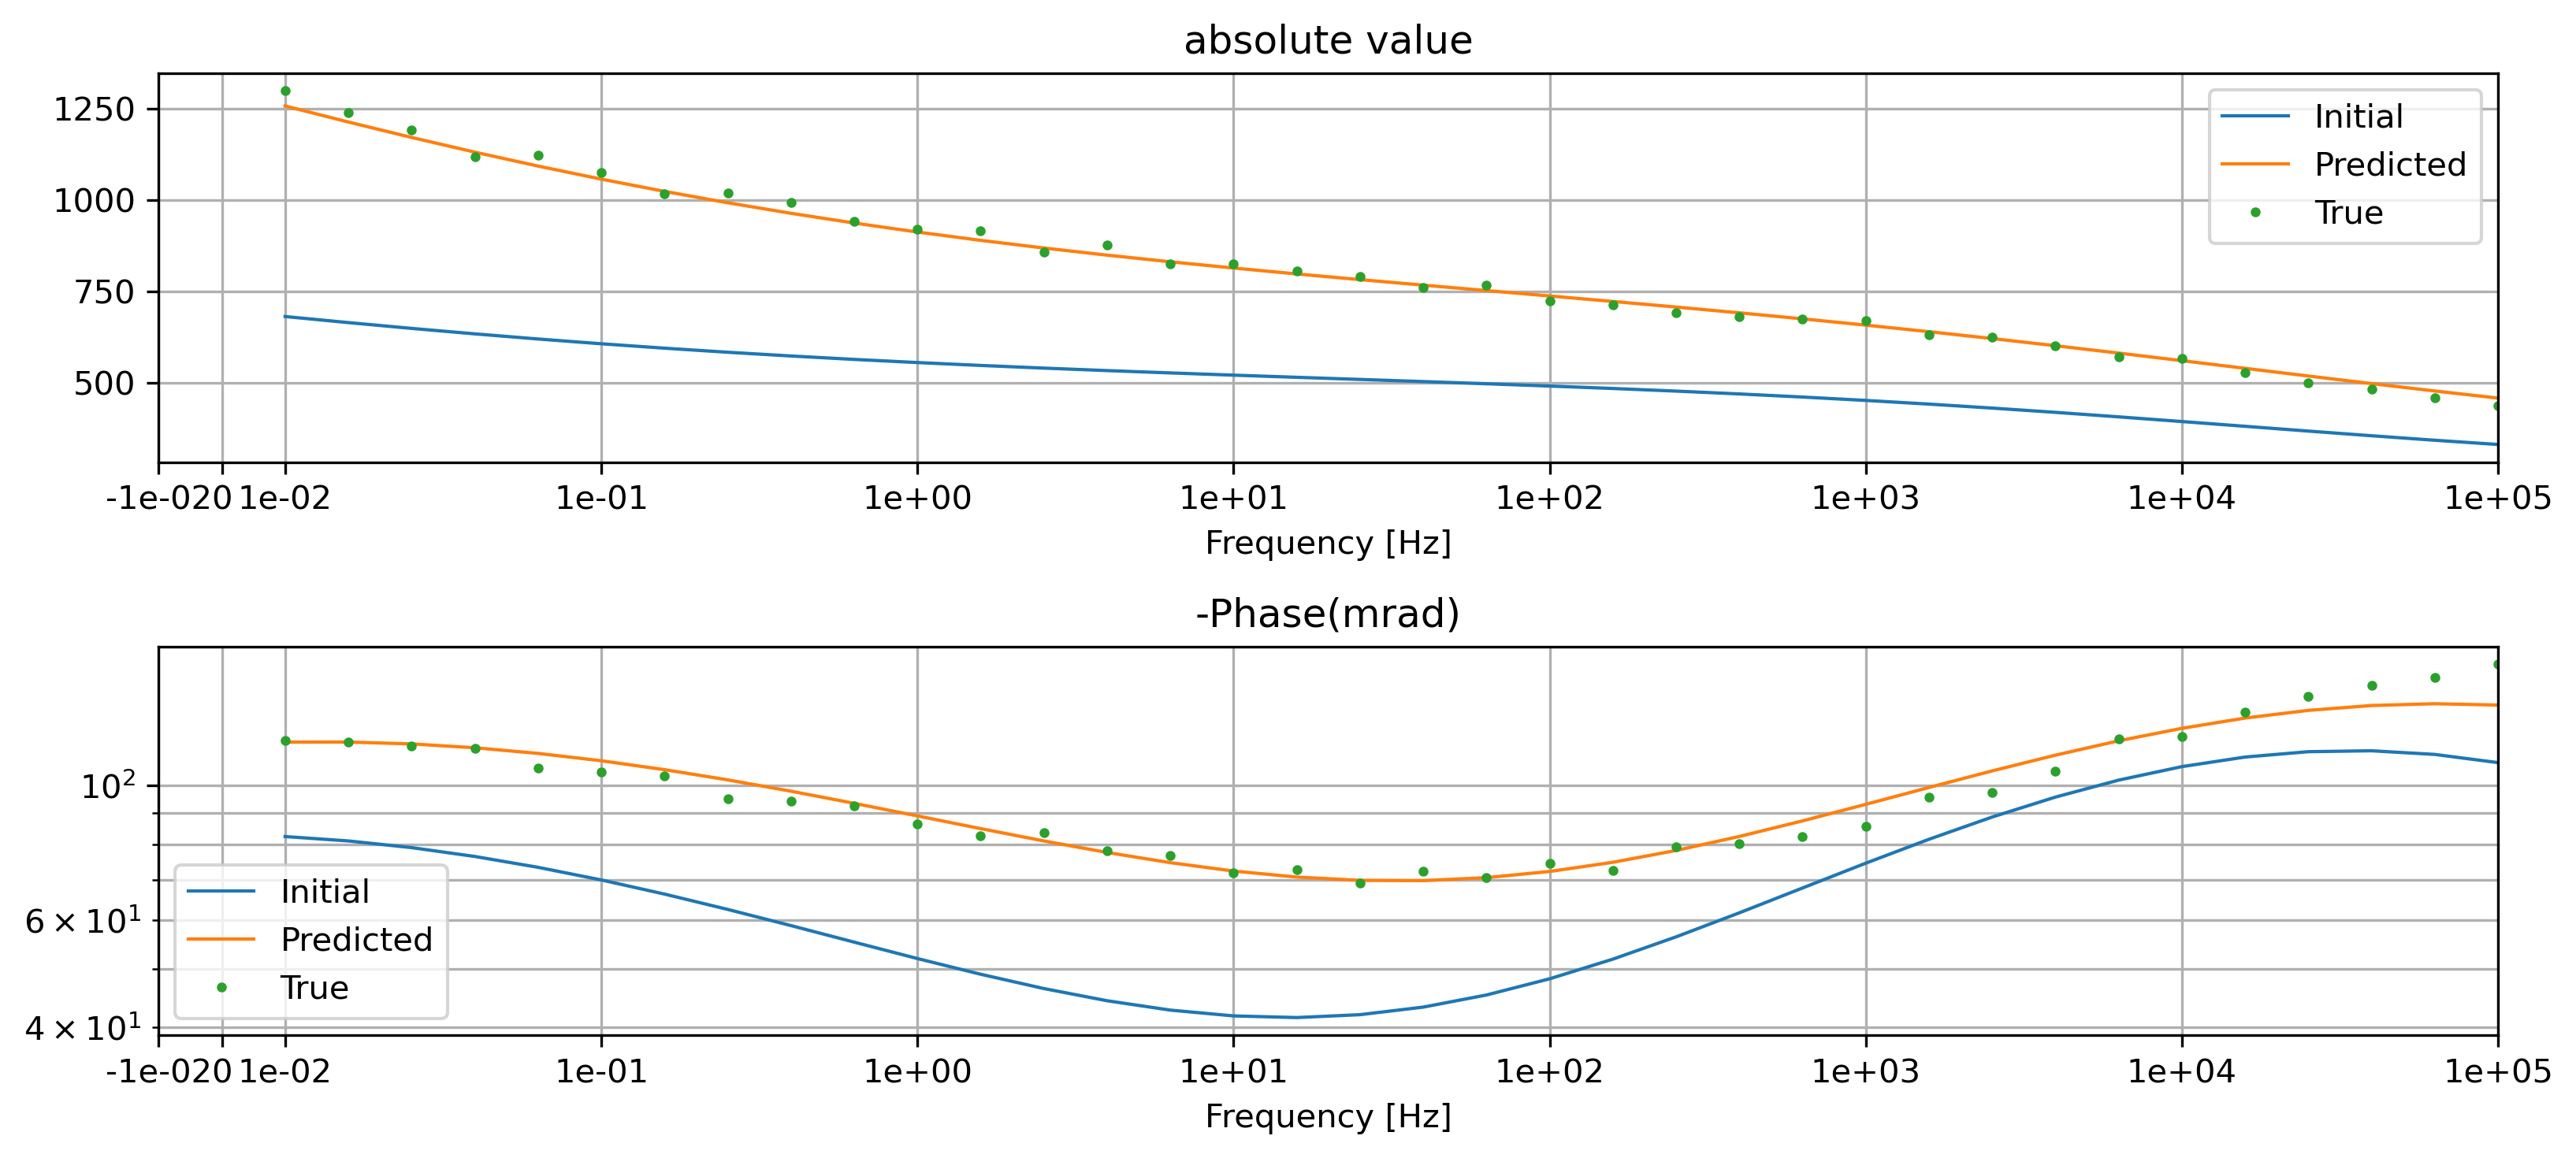

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
ax[0] = PL_pelton.semiplx(x=windows_plot, y=dinit_abs, ax=ax[0], yscale_log=False,
                          color = "C0",label="Initial")
ax[0] = PL_pelton.semiplx(x=windows_plot, y=dest_abs, ax=ax[0], yscale_log=False,
                            color = "C1",label="Predicted")
ax[0] = PL_pelton.semiplx(x=windows_plot, y=dobs_real, ax=ax[0], yscale_log=False,
                 color = "C2",linestyle="",markersize=4.0, marker=".",label="True")
PL_pelton.pl_axes_x(ax=ax[0])
ax[1] = PL_pelton.semiplx(x=windows_plot, y=-dinit_phase, ax=ax[1], yscale_log=True,
                                color = "C0",label="Initial")
ax[1] = PL_pelton.semiplx(x=windows_plot, y=-dest_phase, ax=ax[1], yscale_log=True,
                                color = "C1",label="Predicted")
ax[1] = PL_pelton.semiplx(x=windows_plot, y=-dobs_phase, ax=ax[1], yscale_log=True,
                 color = "C2",linestyle="",markersize=4.0, marker=".",label="True")
PL_pelton.pl_axes_x(ax=ax[1])
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend()
ax[0].set_title('absolute value')
ax[1].set_title('-Phase(mrad)')
plt.tight_layout()

In [18]:
def pelton_res_f_dual_bite(p):
    """
    Pelton dual cole-cole resistivity model
    made easy for PyTorch Auto Diffentiation.
    p[0] : log(res0)
    p[1] : eta1
    p[2] : log(tau1)
    p[3] : c1
    p[4] : eta2
    p[5] : log(tau2)
    p[6] : c2
    """
    iwc1 = (1j * 2. * torch.pi * freq  ) ** p[3] 
    tc1 = torch.exp(-p[2]*p[3])
    iwc2 = (1j * 2. * torch.pi * freq  ) ** p[6]
    tc2 = torch.exp(-p[5]*p[6])
    f = torch.exp(p[0])*(tc1 +(1.0-p[1])*iwc1)/(tc1+iwc1)*(tc2 +(1.0-p[4])*iwc2)/(tc2+iwc2)

    return f

In [19]:
pelton_res_f_dual_bite(parm_true)

tensor([1242.5093-157.6781j, 1197.5197-149.1829j, 1155.1206-140.7352j,
        1115.2734-132.4225j, 1077.9153-124.3213j, 1042.9629-116.4977j,
        1010.3154-109.0079j,  979.8578-101.8984j,  951.4639-95.2075j,
         924.9985-88.9658j,  900.3199-83.1979j,  877.2809-77.9234j,
         855.7302-73.1574j,  835.5133-68.9124j,  816.4742-65.1979j,
         798.4532-62.0222j,  781.2895-59.3915j,  764.8201-57.3105j,
         748.8798-55.7815j,  733.3020-54.8038j,  717.9190-54.3717j,
         702.5625-54.4729j,  687.0670-55.0854j,  671.2712-56.1749j,
         655.0228-57.6913j,  638.1843-59.5657j,  620.6400-61.7079j,
         602.3043-64.0055j,  583.1312-66.3252j,  563.1230-68.5170j,
         542.3376-70.4216j,  520.8922-71.8814j,  498.9624-72.7530j,
         476.7758-72.9216j,  454.5981-72.3125j,  432.7154-70.8994j])